In [0]:
from google.colab import drive
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, optimizers
from keras.applications import InceptionResNetV2
from keras.callbacks import EarlyStopping 
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt

In [0]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# パラメータ

In [0]:
horizontal = 400
vertical = 300
batch_size = 20
target_size = (vertical, horizontal)
epochs = 100
train_len = 200
validation_len = 100
test_len = 73
steps_per_epoch = train_len / batch_size
validation_steps = validation_len / batch_size
test_steps = test_len / batch_size
train_dir = 'drive/My Drive/[your project directory]/image/train/'
validation_dir = 'drive/My Drive/[your project directory]/image/validation/'
test_dir = 'drive/My Drive/[your project directory]/image/test/'

# 前処理, augmentation 

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary')


validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary')

Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


# ネットワークの構築

In [0]:
conv_base = InceptionResNetV2(
    weights=None,
    include_top=False,
    input_shape=(vertical, horizontal, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.adam(lr=1e-4),
    metrics=['acc'])

conv_base.trainable = True

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# 学習

In [0]:
early_stopping = EarlyStopping(patience=5, verbose=1) 

history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping])

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
10/10 [==============================] - 121s 12s/step - loss: 1.6193 - acc: 0.5800 - val_loss: 0.9022 - val_acc: 0.5600
Epoch 2/100
10/10 [==============================] - 36s 4s/step - loss: 0.7316 - acc: 0.6600 - val_loss: 1.4447 - val_acc: 0.5000
Epoch 3/100
10/10 [==============================] - 54s 5s/step - loss: 0.7010 - acc: 0.5700 - val_loss: 0.6322 - val_acc: 0.5200
Epoch 4/100
10/10 [==============================] - 55s 5s/step - loss: 0.6074 - acc: 0.6850 - val_loss: 0.6410 - val_acc: 0.5200
Epoch 5/100
10/10 [==============================] - 53s 5s/step - loss: 0.6071 - acc: 0.6900 - val_loss: 0.7035 - val_acc: 0.5400
Epoch 6/100
10/10 [==============================] - 55s 6s/step - loss: 0.5651 - acc: 0.7000 - val_loss: 0.8824 - val_acc: 0.5200
Epoch 7/100
10/10 [==============================] - 54s 5s/step - loss: 0.5322 - acc: 0.7550 - val_loss: 0.5900 - val_acc: 0.6400
Epoch 8/100
10/10 [==============

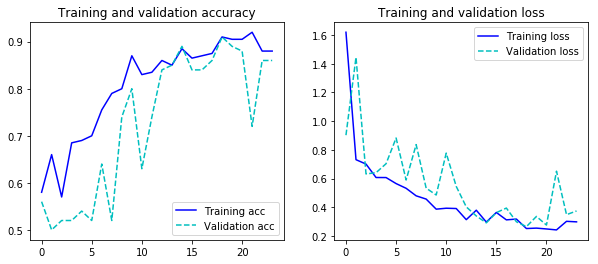

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'c--', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'c--', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# モデルの保存

In [0]:
model.save('./drive/My Drive/[your project directory]/model.h5')

# 推論

In [0]:
model = models.load_model('./drive/My Drive/[your project directory]/model.h5')

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    shuffle = False,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary')

pred_prob = model.predict_generator(test_generator, steps=test_steps)

Found 73 images belonging to 2 classes.


# 評価レポート

In [0]:
pred = list(map(lambda x: 0 if x < 0.5 else 1, pred_prob))
true = test_generator.classes

print('混同行列')
display(pd.DataFrame(confusion_matrix(true,  pred), index=['NG', 'OK'], columns=['NG', 'OK']))
print('accuracy: ', accuracy_score(true,  pred))
print('recall: ', recall_score(true,  pred, pos_label=0))
print('precision: ', precision_score(true,  pred, pos_label=0))

混同行列


,NG,OK
NG,36,0
OK,1,36


accuracy:  0.9863013698630136
recall:  1.0
precision:  0.972972972972973


テストデータ73個のうち、誤分類したデータは1つでありaccuracyが高い。  
recallが1.0なのでOKと予測されたデータは手がかからない。  
precisionも0.97と高いが、NGと予測された物の中にOKがあることを許容できない場合は、NGと予測されたデータは人手でチェックするなどのダブルチェックが必要である。